### Task Vectors are Cross-Modal Demo

In [1]:
%load_ext autoreload
%autoreload 2

import glob
from omegaconf import OmegaConf
import os
from PIL import Image
import torch

import sys
sys.path.append("src")
import xpatch_evaluate, xpatch_helpers, xpatch_dataset

**Define Helper Functions**

In [2]:
MODEL_MAPPING = {os.path.basename(file).split(".")[0]: OmegaConf.load(file) for file in glob.glob("configs/models/*")}

def format_prompt(specification, modality, image_root, remove_last=False):
    if type(specification) is list:
        text, images = xpatch_dataset.format_prompt(specification, modality=modality, remove_last=remove_last, image_root=image_root)
    elif type(specification) is str:
        text, images = specification + ":", []
    else:
        raise NotImplementedError
    return text, images

def preprocess_text(text):
    if ":" not in text:
        raise NotImplementedError("This function assumes the colon is the delimiter and ignores all text after the last colon.")
    # Remove all text after the colon so that final token is the delimiter
    text = text[:text.rfind(":")+1]
    return text

def preprocess_images(images):
    if len(images) == 0:
        return None
    else:
        return images
    
def cross_modal_patching(text, images, query_text, query_images, generate_kwargs, patch_kwargs, patch_model_kwargs, feats_model_kwargs=None, ensemble=False):
    if feats_model_kwargs is None:
        feats_model_kwargs = patch_model_kwargs
    # ==============
    #   Feat Saving
    # ==============
    if ensemble:
        feats = []
        for i in range(len(text)):
            _feats = xpatch_evaluate.embed_prompt(
                **feats_model_kwargs, 
                config=None, 
                text=preprocess_text(text[i]), 
                images=preprocess_images(images[i])
            )[0]
            feats.append(_feats)
        # Average feats
        feats = torch.stack(feats).mean(dim=0)
    else:
        feats = xpatch_evaluate.embed_prompt(
            **feats_model_kwargs, 
            config=None, 
            text=preprocess_text(text), 
            images=preprocess_images(images)
        )[0]
    # ==============
    #    Patching
    # ==============
    # Create batch and set tgt_token to final token
    batch = patch_model_kwargs["processor"](
        text=preprocess_text(query_text), 
        images=preprocess_images(query_images), 
        padding=False, 
        return_tensors="pt"
    )
    tgt_token = torch.tensor(batch["input_ids"].shape[1] - 1, device=patch_model_kwargs["model"].device)
    # Run patching
    output = xpatch_evaluate.patch_layer(
        feats=feats, 
        tgt_batch=batch, 
        tgt_token=tgt_token,
        generate_kwargs=generate_kwargs,
        **patch_model_kwargs,
        **patch_kwargs
    )
    return output

def few_shot_prompting(text, images, query_text, query_images, generate_kwargs, model_kwargs):
    all_text = text + query_text
    all_images = images + query_images
    batch = model_kwargs["processor"](
        text=preprocess_text(all_text), 
        images=preprocess_images(all_images), 
        padding=False, 
        return_tensors="pt"
    )
    output = xpatch_helpers.generate(
        model_kwargs["model"], 
        model_kwargs["processor"], 
        batch, 
        **generate_kwargs
    )[0]
    return output

def print_header(header):
    print("=" * 20)
    print(header)
    print("=" * 20)

**Load the VLM**

In [ ]:
device = "cuda"
model_name = "idefics2" # ["idefics2", "llava", "mantis"]
model_info = MODEL_MAPPING[model_name]

In [4]:
# Load the VLM
model, processor, text_model, model_config = xpatch_evaluate.load_model(model_info["model_id"], device=device)
# Set hparams
model_kwargs = {
    "model": model,
    "processor": processor,
    "text_model": text_model,
    "model_config": model_config,
}
patch_kwargs = {
    "L": model_info["patch_L"],
    "cache_L": model_info["patch_L"]
}
generate_kwargs = {
    "do_sample": False, 
    "max_new_tokens": 5
}

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


**Cross-Modal Transfer**

In [5]:
# ==============================
#       Image ICL Transfer
# ==============================
src_modality, tgt_modality = "image", "text"
image_root = "data/examples/image_icl"
patrick_star_description = "The character is a pink starfish wearing green and purple pants."
query = [{"input": patrick_star_description}]
specification = [
    {"image": "Sandy_Cheeks.png", "output": "Sandy Cheeks"},
    {"image": "Mrs_Puff.png",  "output": "Mrs. Puff"},
    {"image": "Mr_Krabs.png",  "output": "Mr. Krabs"},
]

# ==============================
#      Instruction Transfer
# ==============================
# src_modality, tgt_modality = "text", "image"
# image_root = "data/examples/instruction"
# query = [{"image": "Swamp_Wallaby.png"}]
# specification = "The term for the baby of the animal"

Specification


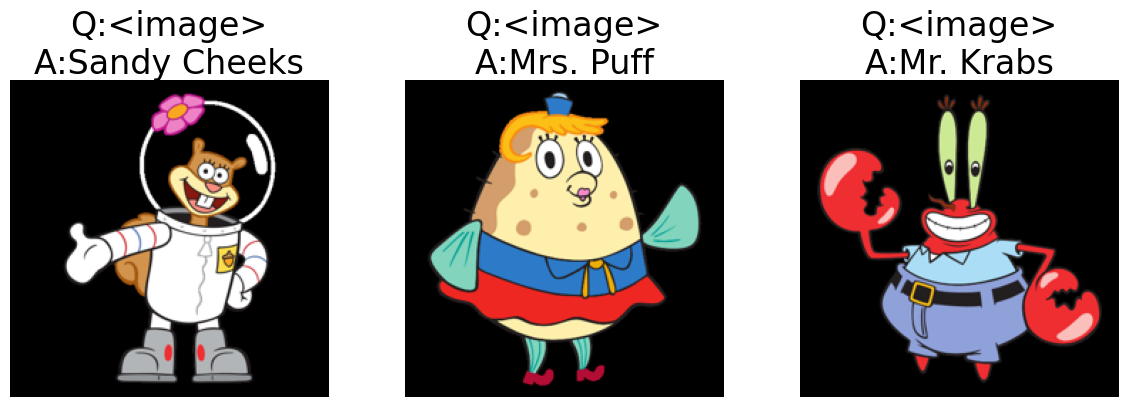

Query
Q:The character is a pink starfish wearing green and purple pants.
A:


Output
Few Shot Prompting (xBase): 'Plankton\n\n'
Cross Modal Patching (xPatch): 'Patrick Star.\n\n'


In [6]:
text, images = format_prompt(specification, src_modality, image_root)
query_text, query_images = format_prompt(query, tgt_modality, image_root)

xbase = few_shot_prompting(text, images, query_text, query_images, generate_kwargs, model_kwargs)
xpatch = cross_modal_patching(text, images, query_text, query_images, generate_kwargs, patch_kwargs, patch_model_kwargs=model_kwargs)

print_header("Specification")
xpatch_helpers.plot_icl([_text for _text in text.split("\n\n") if _text], images)

print_header("Query")
print(query_text)
if query_images:
  display(query_images[0])

print_header("Output")
print("Few Shot Prompting (xBase):", repr(xbase))
print("Cross Modal Patching (xPatch):", repr(xpatch))

**LLM to VLM Transfer**

In [7]:
llm_model_name = "mistral" # ["mistral", "vicuna"]
llm_model_info = MODEL_MAPPING[llm_model_name]
llm_model, llm_processor, llm_text_model, llm_model_config = xpatch_evaluate.load_model(llm_model_info["model_id"], device=device)
llm_model_kwargs = {
    "model": llm_model,
    "processor": llm_processor,
    "text_model": llm_text_model,
    "model_config": llm_model_config,
}

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
# ==============================
#        Text ICL Transfer
# ==============================
src_modality, tgt_modality = "text", "image"
image_root = "data/examples/text_icl"
query = [{"image": "France.png"}]
specification = [
    {"input": "Peru", "output": "Lima"},
    {"input": "Australia", "output": "Canberra"},
    {"input": "Micronesia", "output": "Palikir"},
    {"input": "Cameroon", "output": "Yaounde"},
    {"input": "South Korea", "output": "Seoul"}
]

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


Specification


/home/g-luo/remote_home/task_vectors_are_cross_modal/src/xpatch_helpers.py:276: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


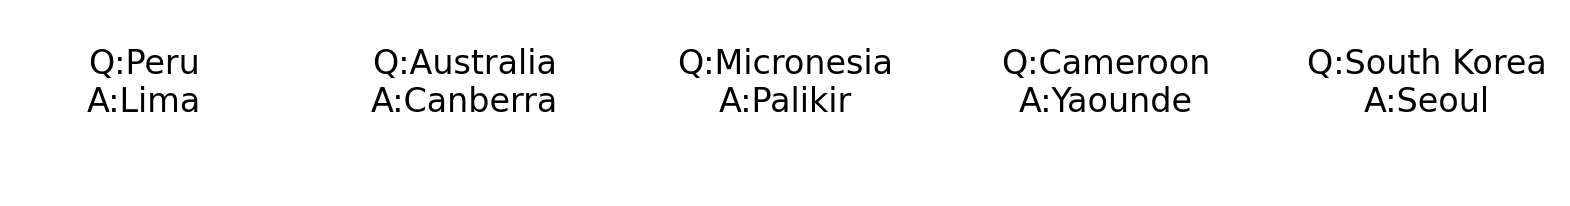

Query
Q:<image>
A:




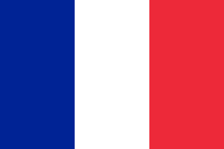

Output
VLM Few Shot Prompting (xBase): 'France\n\nQ:'
LLM to VLM Patching (xPatch): 'Paris.'


In [9]:
text, images = format_prompt(specification, src_modality, image_root)
query_text, query_images = format_prompt(query, tgt_modality, image_root)

xbase = few_shot_prompting(text, images, query_text, query_images, generate_kwargs, model_kwargs)
xpatch = cross_modal_patching(text, images, query_text, query_images, generate_kwargs, patch_kwargs, patch_model_kwargs=model_kwargs, feats_model_kwargs=llm_model_kwargs)

print_header("Specification")
xpatch_helpers.plot_icl([_text for _text in text.split("\n\n") if _text], images)

print_header("Query")
print(query_text)
if query_images:
  display(query_images[0])
  
print_header("Output")
print("VLM Few Shot Prompting (xBase):", repr(xbase))
print("LLM to VLM Patching (xPatch):", repr(xpatch))

**Vector Ensembling**

In [10]:
# ===================================
#   Text ICL + Instruction Transfer
# ===================================
src_modality, tgt_modality = "text", "image"
image_root = "data/examples/text_icl"
query = [{"image": "France.png"}]
specifications = {
    "Text ICL, n=3": [
        {"input": "Peru", "output": "Lima"},
        {"input": "Australia", "output": "Canberra"},
        {"input": "Micronesia", "output": "Palikir"}
    ],
    "Instruction": "The capital city of the country"
}

Query
Q:<image>
A:




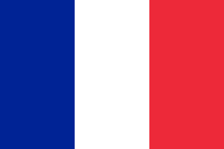

Output
Ensemble Text ICL, n=3 (xPatch): 'Port-au-Pr'
Ensemble Text ICL, n=3 + Instruction (xPatch): 'Paris.'


In [11]:
print_header("Query")
query_text, query_images = format_prompt(query, tgt_modality, image_root)
print(query_text)
if query_images:
  display(query_images[0])

print_header("Output")
names = []
text, images = [], []
for name, specification in specifications.items():
    # Ensemble another specification
    _text, _images = format_prompt(specification, src_modality, image_root)
    text.append(_text)
    images.append(_images)
    names.append(name)

    xpatch = cross_modal_patching(text, images, query_text, query_images, generate_kwargs, patch_kwargs, patch_model_kwargs=model_kwargs, ensemble=True)
    print(f"Ensemble {' + '.join(names)} (xPatch):", repr(xpatch))

**Task Conflict**

In [12]:
# ===================================
#       Instruction Conflict
# ===================================
src_modality, tgt_modality = "text", "image"
image_root = "data/examples/task_conflict"
instruction_xbase = "What is on top of the meat"
instruction_xpatch = "What is the green vegetable"
query = [{"image": "VQA_Food.png"}]

Specification
What is the green vegetable:

Query
Q:<image>What is on top of the meat?
A:




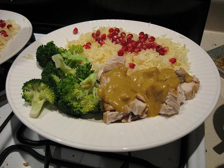

Output
Instruction xBase: 'Sauce.'
+ Instruction xPatch: 'broccoli\n\n'


In [13]:
text, images = format_prompt(instruction_xpatch, src_modality, image_root)
query_text, query_images = format_prompt(query, tgt_modality, image_root)
query_text = query_text.replace("<image>", f"<image>{instruction_xbase}?")
  
xbase = few_shot_prompting("", [], query_text, query_images, generate_kwargs, model_kwargs)
xpatch =  cross_modal_patching(text, images, query_text, query_images, generate_kwargs, patch_kwargs, patch_model_kwargs=model_kwargs)

print_header("Specification")
print(text)

print()
print_header("Query")
print(query_text)
if query_images:
  display(query_images[0])

print_header("Output")
print("Instruction xBase:", repr(xbase))
print("+ Instruction xPatch:", repr(xpatch))